In [2]:
import numpy as np
from matplotlib import pyplot as plt
from data.letter_patterns import create_letter_patterns

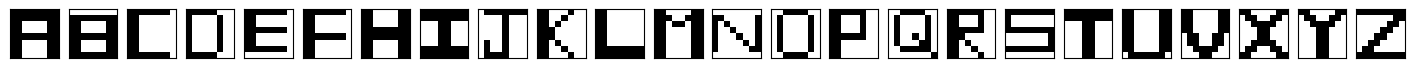

In [3]:
patterns = create_letter_patterns()
X = np.array([pattern.reshape(-1) for pattern in patterns.values()])
labels = list(patterns.keys()) 

def graph_plotter(patterns, height=8, width=8):
    num_of_patterns = len(patterns)
    fig, ax  = plt.subplots(1, num_of_patterns, figsize=(18,18))
    for i in range(0,num_of_patterns):
        ax[i].matshow(patterns[i].reshape((height, width)), cmap='gray')
        ax[i].set_xticks([])
        ax[i].set_yticks([])


graph_plotter(X)

In [4]:
class ART():

    def __init__(self, n_clusters, learning_rate):
        self.n_clusters = n_clusters
        self.learning_rate = learning_rate
        self.weight_2_TO_1 = None
        self.weight_1_TO_2 = None
        
    def train(self, X, vigilance, epochs=1):
        n_samples, n_features = X.shape
        
        if self.weight_2_TO_1 is None:
            self.weight_2_TO_1 = np.ones((n_features, self.n_clusters)) * 0.5
        if self.weight_1_TO_2 is None:
            scaler = self.learning_rate / (self.learning_rate + self.n_clusters - 1)
            self.weight_1_TO_2 = scaler * self.weight_2_TO_1.T

        weight_changes = []
        
        for epoch in range(epochs):
            prev_weights = np.copy(self.weight_2_TO_1)
            classes = np.zeros(n_samples)
    
            for i, p in enumerate(X):
                disabled_neurons = []
                reseted_values = []
                reset = True
    
                while reset:
                    output1 = p
                    input2 = np.dot(self.weight_1_TO_2, output1.T)
    
                    output2 = np.zeros(input2.size)
                    input2[disabled_neurons] = -np.inf
                    winner_index = input2.argmax()
                    output2[winner_index] = 1
    
                    expectation = np.dot(self.weight_2_TO_1, output2)
                    output1 = np.logical_and(p, expectation).astype(int)
    
                    reset_value = np.dot(output1.T, output1) / np.dot(p.T, p)
                    reset = reset_value < vigilance
    
                    if reset:
                        disabled_neurons.append(winner_index)
                        reseted_values.append((reset_value, winner_index))
    
                    if len(disabled_neurons) >= self.n_clusters:
                        reset = False
                        winner_index = None
    
                    if not reset:
                        if winner_index is not None:
                            self.weight_1_TO_2[winner_index, :] = (self.learning_rate * output1) / (
                                self.learning_rate + np.dot(output1.T, output1) - 1
                            )
                            self.weight_2_TO_1[:, winner_index] = output1
                        else:
                            winner_index = max(reseted_values)[1]
    
                        classes[i] = winner_index
                        
            weight_change = np.linalg.norm(self.weight_2_TO_1 - prev_weights)
            weight_changes.append(weight_change)
            prev_weights = np.copy(self.weight_2_TO_1)

        print(f"{epochs} Epochs completed using vigilance value {vigilance}")

        return classes, weight_changes

    def visualize_vigilance_impact(self, X, vigilance_range=np.arange(0.1, 1.1, 0.1), epochs=1):
        n_clusters = []
        original_weight_2_TO_1 = self.weight_2_TO_1
        original_weight_1_TO_2 = self.weight_1_TO_2
        
        for vigilance in vigilance_range:
            self.weight_2_TO_1 = None
            self.weight_1_TO_2 = None
            classes, weights_changes = self.train(X, vigilance, epochs)
            n_clusters.append(len(np.unique(classes)))
        
        self.weight_2_TO_1 = original_weight_2_TO_1
        self.weight_1_TO_2 = original_weight_1_TO_2
        
        plt.figure(figsize=(10, 5))
        plt.plot(vigilance_range, n_clusters, marker='o')
        plt.title(f'Impact of Vigilance Parameter on Number of Clusters (Epochs: {epochs})')
        plt.xlabel('Vigilance')
        plt.xticks(np.arange(0, 1.1, 0.1))
        plt.ylabel('Number of Clusters')
        plt.yticks(range(min(n_clusters), max(n_clusters)+1))
        plt.grid(True)
        plt.show()

    def visualize_weight_changes(self, weight_changes):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(weight_changes) + 1), weight_changes, marker='o')
        plt.title('ART Weight Changes Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Weight Change (Frobenius Norm)')
        plt.grid(True)
        plt.show()

10 Epochs completed using vigilance value 0.5


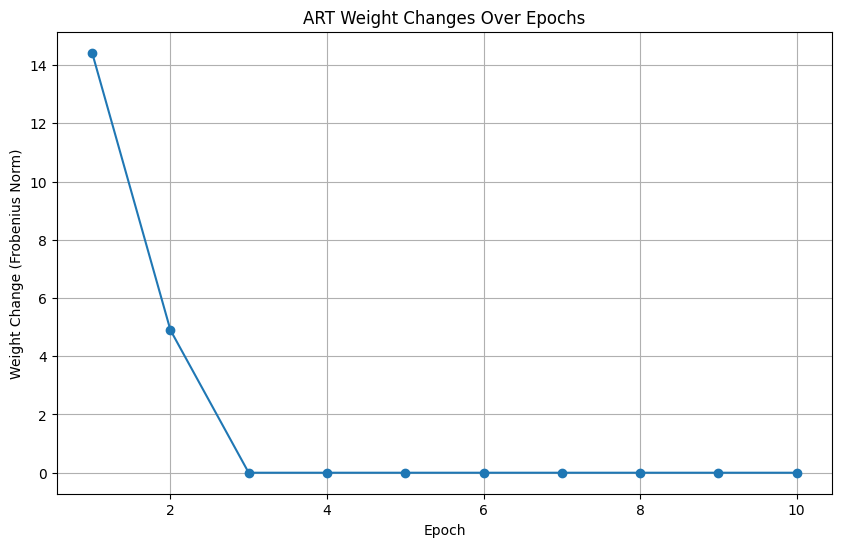

In [8]:
n_clusters = X.shape[0]
learning_rate = 0.5
vigilance = 0.5
epochs = 10

art = ART(n_clusters, learning_rate)
classes, weight_changes = art.train(X, vigilance, epochs)
art.visualize_weight_changes(weight_changes)


1 Epochs completed using vigilance value 0.1
1 Epochs completed using vigilance value 0.2
1 Epochs completed using vigilance value 0.30000000000000004
1 Epochs completed using vigilance value 0.4
1 Epochs completed using vigilance value 0.5
1 Epochs completed using vigilance value 0.6
1 Epochs completed using vigilance value 0.7000000000000001
1 Epochs completed using vigilance value 0.8
1 Epochs completed using vigilance value 0.9
1 Epochs completed using vigilance value 1.0


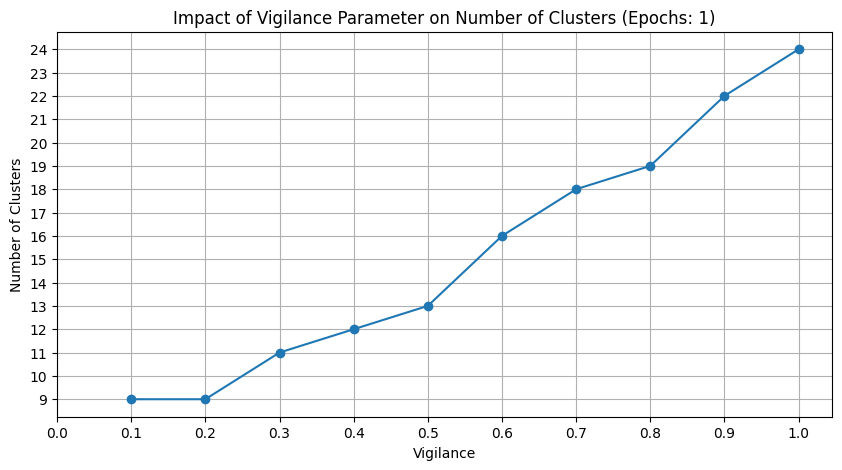

In [9]:
art.visualize_vigilance_impact(X, epochs = 1) 

In [ ]:
art.visualize_vigilance_impact(X, epochs = 2) 

In [ ]:
art.visualize_vigilance_impact(X, epochs = 40) 

In [11]:
class ART1Calculator:
    def __init__(self, input_size, vigilance = 0.5):
        self.input_size = input_size
        self.categories = []
        self.bottom_up_weights = []
        self.top_down_weights = [] 
        self.vigilance = vigilance 
        self.L = input_size
        self.F2_active = []
        self.category_labels = []

    def add_category(self, category_vector, category_label):
        self.categories.append(np.array(category_vector, dtype=int))
        self.top_down_weights.append(np.array(category_vector, dtype=int)) 
        self.category_labels.append([category_label])

        L = self.input_size
        w_td_norm = np.sum(category_vector)
        w_bu = (L / (L - 1 + w_td_norm)) * category_vector
        self.bottom_up_weights.append(w_bu)
        

    def calculate_similarity(self, input_vector):
        input_vector = np.array(input_vector, dtype=int)
        similarities = []
        for j, category in enumerate(self.categories):
            intersection = np.minimum(input_vector, self.bottom_up_weights[j])
            Tj = np.sum(intersection) #Recalcuate if category is deactivated. 
            similarities.append(Tj)
        return similarities

    def activate_F2_layer(self, similarities):
        active_indices = [i for i, act in enumerate(self.F2_active) if act]
        if not active_indices:
            return [], None
        
        winner_index = max(active_indices, key=lambda i: similarities[i])
        F2_activations = [0] * len(similarities)
        F2_activations[winner_index] = 1
        return F2_activations, winner_index

    def activate_F1_layer(self, input_vector, F2_winner_index):
        if F2_winner_index is None:
            return input_vector  # F1 = x if F2 is inactive
        else:
            # F1 = x ∩ w_J^td
            return np.minimum(input_vector, self.top_down_weights[F2_winner_index])

    
    def resonance_test(self, input_vector, F1_activation):
        return np.sum(F1_activation) / np.sum(input_vector)
        
    def update_weights(self, category_index, input_vector):
        self.top_down_weights[category_index] = np.minimum(input_vector, self.top_down_weights[category_index])
        w_td_new = self.top_down_weights[category_index]
        w_td_new_norm = np.sum(w_td_new)
        self.bottom_up_weights[category_index] = (self.L / (self.L - 1 + w_td_new_norm)) * w_td_new

    
    def process_input(self, input_vector, input_label):
        input_vector = np.array(input_vector, dtype=int)
        F1_activation = input_vector
        resonance = False
        winner_index = None
        match_value = 0
        self.F2_active = [True] * len(self.categories)
    
        while not resonance:
            similarities = self.calculate_similarity(F1_activation)
            F2_activations, candidate_index = self.activate_F2_layer(similarities)
            
            if candidate_index is None:
                self.add_category(input_vector,input_label)
                winner_index = len(self.categories) - 1
                resonance = True
            else:
                F1_activation = self.activate_F1_layer(input_vector, candidate_index)
                match_value = self.resonance_test(input_vector, F1_activation)
                
                if match_value >= self.vigilance:
                    winner_index = candidate_index
                    resonance = True
                    self.update_weights(winner_index, input_vector)
                    self.category_labels[winner_index].append(input_label)
                else:
                    self.F2_active[candidate_index] = False
    
        self.F2_active = [True] * len(self.categories)
    
        return F1_activation, similarities, F2_activations, winner_index, match_value, resonance

    def display_categories(self):
        for i, category in enumerate(self.category_labels):
            print(f"Category {i+1}: {category}")


In [13]:
art = ART1Calculator(64, vigilance=0.5)

for i, pattern in enumerate(X):
    label = labels[i]
    F1_activation, similarities, F2_activations, winner_index, match_value, resonance = art.process_input(input_vector=pattern, input_label=label)

    print("\nFinal F1 activation:", F1_activation)
    print("Similarities:", similarities)
    print("F2 layer activations:", F2_activations)

    if winner_index is not None:
        print(f"\nWinning category: Category {winner_index + 1}")
        print(f"Match value (Mj): {match_value:.4f}")
        print(f"Resonance: {resonance}")
        if resonance:
            print("Category accepted and updated")
        else:
            print("Error: Resonance should be True at this point")
    else:
        print("\nError: No winning category found")

    print("\nTotal number of categories:", len(art.categories))


art.display_categories()


Final F1 activation: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0]
Similarities: []
F2 layer activations: []

Winning category: Category 1
Match value (Mj): 0.0000
Resonance: True
Category accepted and updated

Total number of categories: 1

Final F1 activation: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Similarities: [np.float64(12.337349397590362)]
F2 layer activations: [1]

Winning category: Category 1
Match value (Mj): 0.6667
Resonance: True
Category accepted and updated

Total number of categories: 1

Final F1 activation: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Similarities: [np.float64(12.962025316455696)]
F2 layer activations: []

Winning category: Category 2
Match value (Mj): 0.4211
Resonance: True
Category accepted a